In [1]:
# THis script loads images cropped by CropCrossings notebook.  It then counts foci in every iamge
# this notebook was just for algorithm develpment.  There is anow a function
# "count_islands" in count_peaks.py that does everything

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
from nuclei.count_islands import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)




12 islands detected


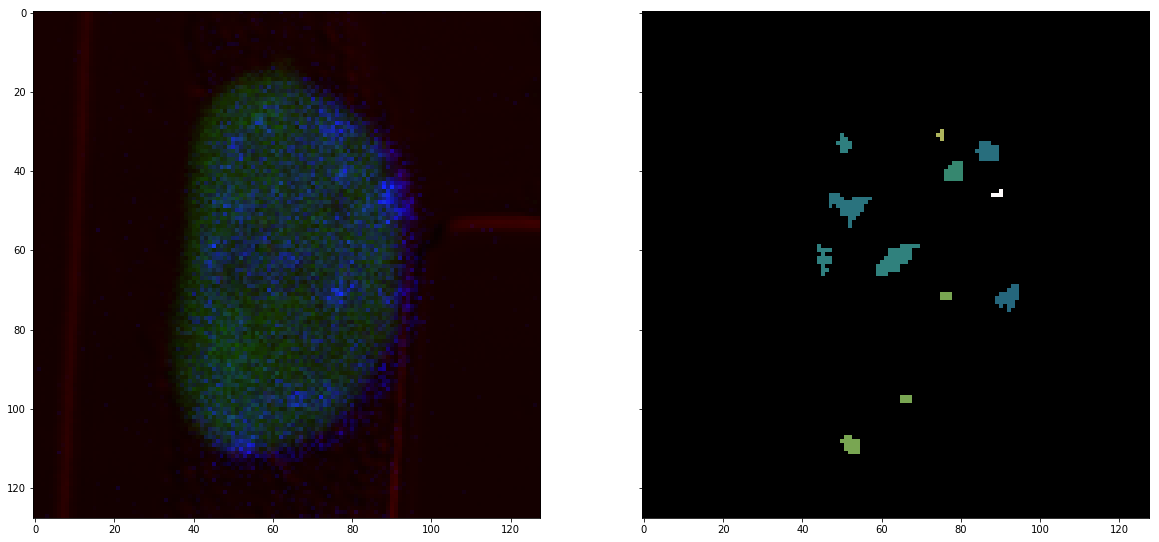

In [2]:
# test the all in one function that does the same thing as the following blocks.
item_id = '5ad968af1fbb9005ff724b9b'
#item_id = '5ada5e3a1fbb9052b6c0d19a'
images = g.read_item_images(item_id)

image = images[19]
blue_image = image[...,2]
island_map, island_count = count_islands(blue_image, 50, 3, 18, 50)

print("%d islands detected"%island_count)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,20))
ax[0].imshow(image)
ax[1].imshow(island_map)





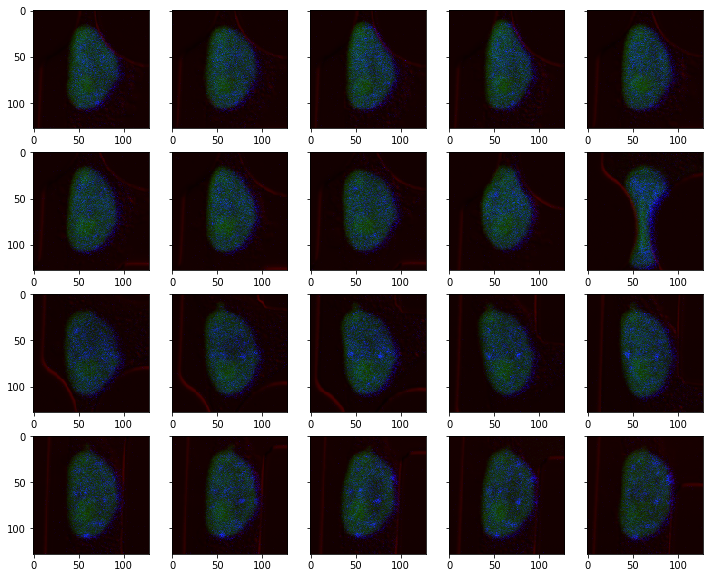

In [2]:
# read images from a girder lightbox

#item_id = '5ad8a5111fbb9005ff71ce11'
#item_id = '5ad8a57f1fbb9005ff71ce3a'
#item_id = '5ad8a6921fbb9005ff71ce63'
#item_id = '5ad8a2e81fbb9005ff71cde8'
#item_id = '5ad8aa121fbb9005ff71ce94'
#item_id = '5ad8aa4f1fbb9005ff71cebd'

item_id = '5ad968af1fbb9005ff724b9b'
#item_id = '5ada5e3a1fbb9052b6c0d19a'
images = g.read_item_images(item_id)

fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(images):
            ax[x][y].imshow(images[count], aspect="auto")
        count += 1




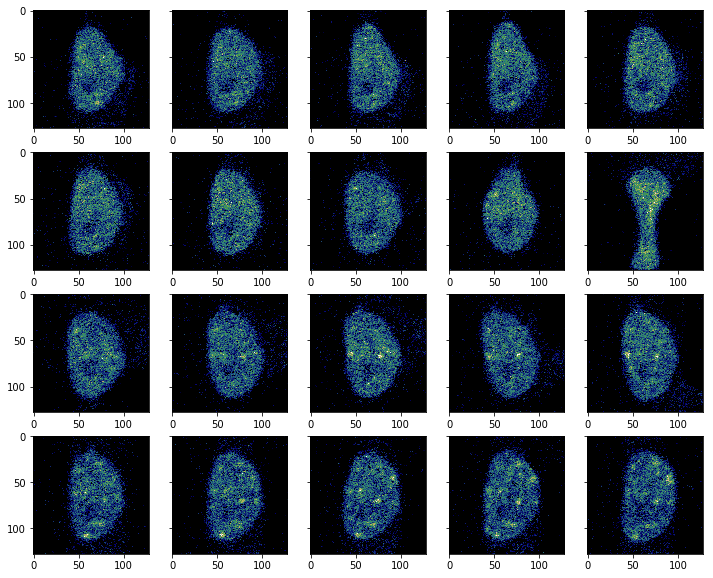

In [3]:
# extract just the opencv blue (normal red) channel (seems that most foci are in this channel)
# Note that matplotlib uses a color map when rendering single channel images.
blue_images = [im[...,2] for im in images]


fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(blue_images):
            ax[x][y].imshow(blue_images[count], aspect="auto")
        count += 1

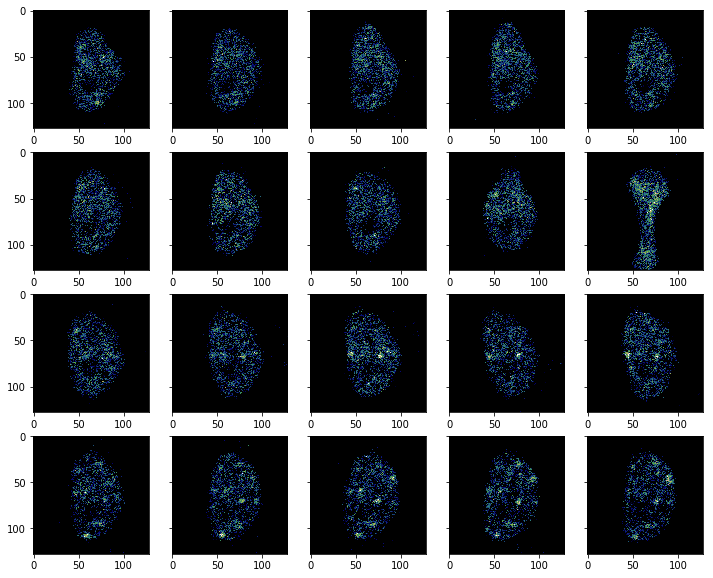

In [4]:
def clip(img):
    # change this to isolate the spots after filtering
    threshold = 50.0 # 140.0
    #out = img.clip(0,255).astype(np.uint8)
    out = np.clip(img,threshold,255) -  threshold
    return out


clip_images = [clip(im) for im in blue_images]

fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(clip_images):
            ax[x][y].imshow(clip_images[count], aspect="auto")
        count += 1


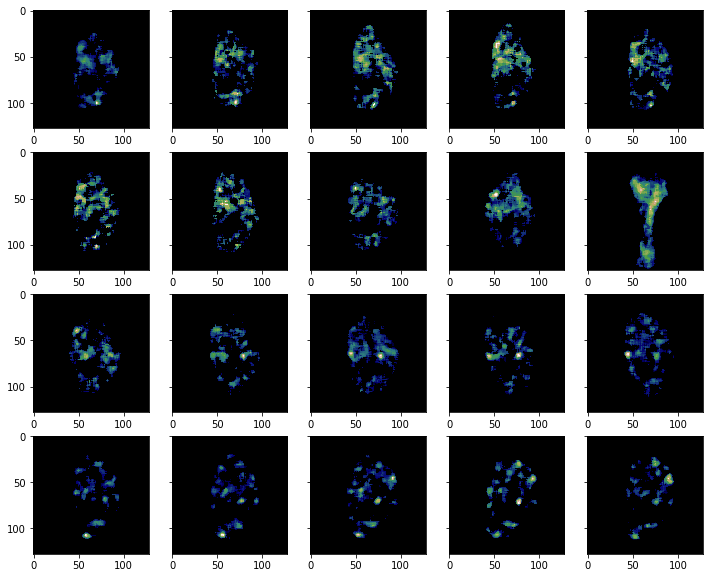

In [5]:
import scipy.signal

median_images = [scipy.signal.medfilt(im, kernel_size=(5,5)) for im in clip_images]

fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(median_images):
            ax[x][y].imshow(median_images[count], aspect="auto")
        count += 1



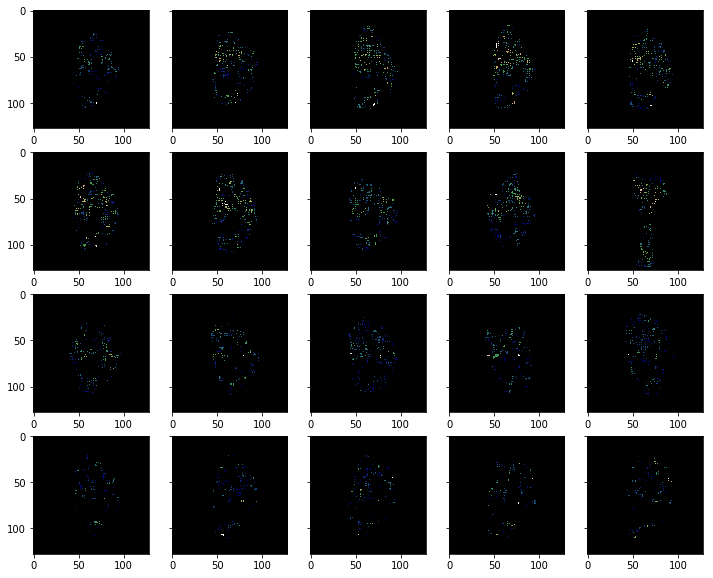

In [6]:
# what does the maximum filter do?  I thknk it is like continuous dilation.
# maximum of a neighborhood (why 2x2 and not 3x3?)
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

# eight neighbor connectivity
neighborhood = generate_binary_structure(2, 2)

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    All non peak pixels are set to zero.
    return it returned.
    """
    peaks = np.array(image)

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2, 2)

    # apply the local maximum filter; all pixel of maximal value
    # in their neighborhood are set to 1
    peaks[maximum_filter(peaks, footprint=neighborhood) != peaks] = 0

    return peaks


# apply the local maximum filter; all pixel of maximal value
# in their neighborhood are set to 1

#maximum_images = [maximum_filter(im, footprint=neighborhood) for im in clip_images]
#maximum_images = [local_max(im, footprint=neighborhood) for im in clip_images]
maximum_images = [detect_peaks(im) for im in median_images]


fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(maximum_images):
            ax[x][y].imshow(maximum_images[count], aspect="auto")
        count += 1



End conndition


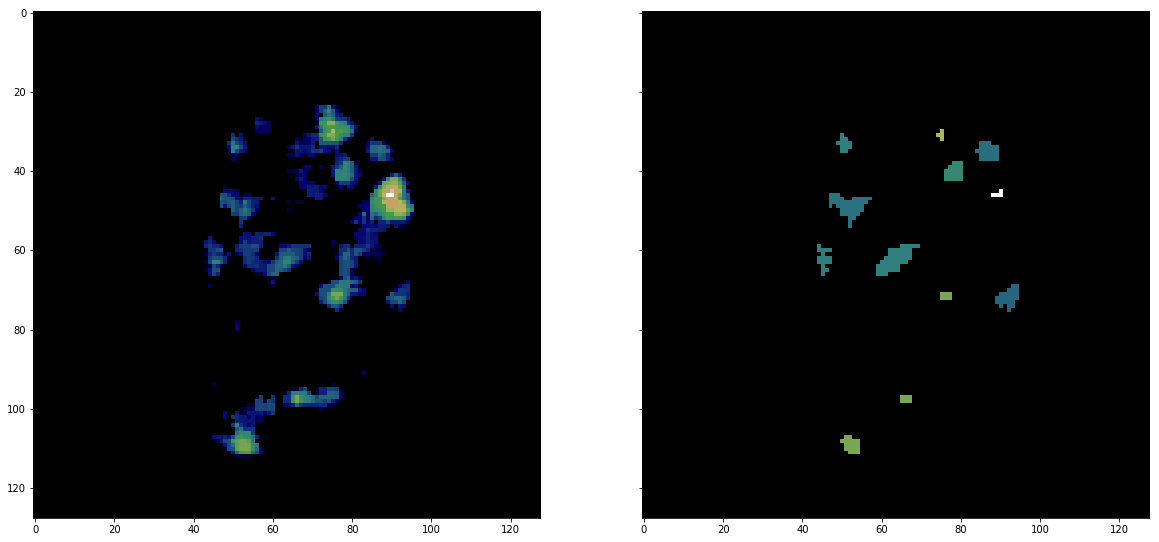

In [33]:
# turn the peaks into islands by filtering out the ones that
# do not have a deep enough valley or do not meet the area criteria.

# I could count the islands wothout generating the islands map,
# but I need the map for debugging.

# wow, this function was a real pain to get working.
# islands and peaks are modified (largest peakis moved to islands)
# returns true if there are more peaks to process.
def fill_max_island(image, peaks, islands, island_height):
    # find the location and value of the highest peak
    ix = np.argmax(np.max(peaks, axis=0))
    iy = np.argmax(peaks[:,ix])
    peak_height = peaks[iy, ix]
    if peak_height == 0:
        print("End conndition")
        return False
    #print(np.max(peaks))
    ret,mask = cv2.threshold(image, peak_height-island_height, 255, cv2.THRESH_BINARY_INV)
    # mask for flood fill has to be paddeed with 1 layers.
    mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 1).astype(np.uint8)
    island = np.zeros(image.shape, dtype=np.uint8)
    cv2.floodFill(island, mask, (ix, iy), 1)
    island_area = np.sum(island)
    #print("island %s, peak=%f, area=%d"%((ix, iy), peak_height, island_area))
    # only keep this island if it does not bleed over into a higher island.
    #print('area = %d, %f, %f'%(island_area, np.max(image*island), peak_height))
    if np.max(image*island) <= peak_height:
        # TODO: Select by area too.
        # add the island to the output map.
        #islands.add(island*peak_height)
        #print("before islands sum = ", np.sum(islands))
        islands[...] = islands + (island*peak_height)
        #print("after islands sum = ", np.sum(islands))
    #else:
    #    print("Valley not deep enough")
    #    print('max elevation %f'%np.max(image*island))
    # remove the peak (and any lower peaks also part of the island) from the peak map.
    peaks[island != 0] = 0
    #print("island sum = ", np.sum(island))
    #print("Peaks sum = ", np.sum(peaks))
    return True

def peaks_to_islands(image, peaks, island_height):
    # image is the original image,  c is the image where every non local maximum is set to 0.
    # Flood fill is used to grow peaks into islands of height c. Any peaks that are not
    # separated by a valley of depth c are merged.
    islands = np.zeros(peaks.shape, dtype=np.uint8)    
    count = 0
    # keep generating island, peak by peak.
    while fill_max_island(image, peaks, islands, island_height):
        count = count + 1
        # This should not be necessary, but infinite loops are painful.
        if count > 100:
            return islands
    return islands

def generate_islands(image, island_height):
    # Detects every local maximum. They need to be filtered to give anything useful/
    peaks = detect_peaks(image)
    return peaks_to_islands(image, peaks, island_height)

#image = median_images[0]
#ret,mask = cv2.threshold(image, 50, 256, cv2.THRESH_BINARY)


#island_images = []
#for i,image in enumerate(median_images):
#    islands = merge_peaks(image, maximum_images[i], 100)
#    island_images.append(islands)

image = median_images[19]
islands = generate_islands(image, 18)


fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,20))
ax[0].imshow(image)
ax[1].imshow(islands)
#plt.imshow(islands)
